In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

import gspread
from oauth2client.service_account import ServiceAccountCredentials


from plotnine import *

In [2]:
warnings.filterwarnings('ignore')

In [3]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

In [5]:
def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [6]:
def gs_append(url, credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json', scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']) : 
    
    credentials = ServiceAccountCredentials.from_json_keyfile_name(credential_path, scope)
    
    gc = gspread.authorize(credentials)
    doc = gc.open_by_url(url)
    
    sheet_name = re.search(string = str(doc.get_worksheet(0)), pattern = r"\'(.*)\'").group(0)[1:-1]
    sheet = doc.worksheet(sheet_name)
    
    sheet_content = sheet.get_all_values()
    
    df_ = pd.DataFrame(sheet_content[1:], columns = sheet_content[0])
    
    return df_

In [7]:
def read_bql(file_name) :
    with open(file_name, "r") as f :
        bql = f.read()
    return bql

In [21]:
adorder_with_tag = bigquery_to_pandas(read_bql("../bql/adorder_with_tag.bql"))

In [22]:
adorder_with_tag.slug.nunique()

463

In [23]:
adorder_with_tag[adorder_with_tag.tags.notna()].slug.nunique()

137

In [29]:
# advice = bigquery_to_pandas(read_bql("../bql/advice_chk.bql"))
advicet = bigquery_to_pandas(read_bql("../bql/advicetransaction.bql"))

In [30]:
def get_gini(df, val_col, color = "red", plot_tf = True) :
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    
    if plot_tf == True :
        print((
            ggplot(data = tmp) +
            geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6) +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))
    
    return (tri - lorenz) / tri

In [31]:
advicet.shape[0]

4579

In [33]:
advicet[(advicet.metadata_context == 'category') & (advicet.metadata_extraInfo != advicet.metadata_contextAdditional)].shape[0]

1360

In [34]:
advicet[(advicet.metadata_context == 'category') & (advicet.metadata_extraInfo != advicet.metadata_contextAdditional)].metadata_contextAdditional.value_counts()[:10]

디지털 성범죄          73
이혼               66
임대차              64
노동/인사            56
폭행/협박/상해 일반      52
지식재산권/엔터         49
교통사고/도주          38
기타 재산범죄          36
성폭력/강제추행 등       36
건축/부동산 일반,임대차    35
Name: metadata_contextAdditional, dtype: int64

In [35]:
for i in advicet[(advicet.metadata_context == 'category') & (advicet.metadata_extraInfo != advicet.metadata_contextAdditional)].metadata_contextAdditional.value_counts()[:10].index :
    print(advicet[advicet.metadata_contextAdditional.fillna("").str.contains(i)].shape[0])

217
199
334
152
202
88
99
101
177
38


분야 별 유료 상담에 대한 변호사 불평등도

임대차


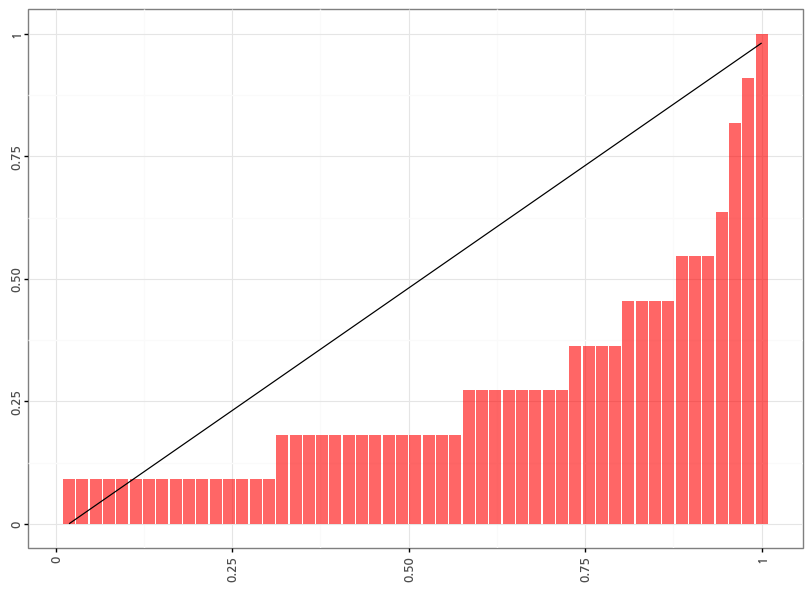


사이버 명예훼손/모욕


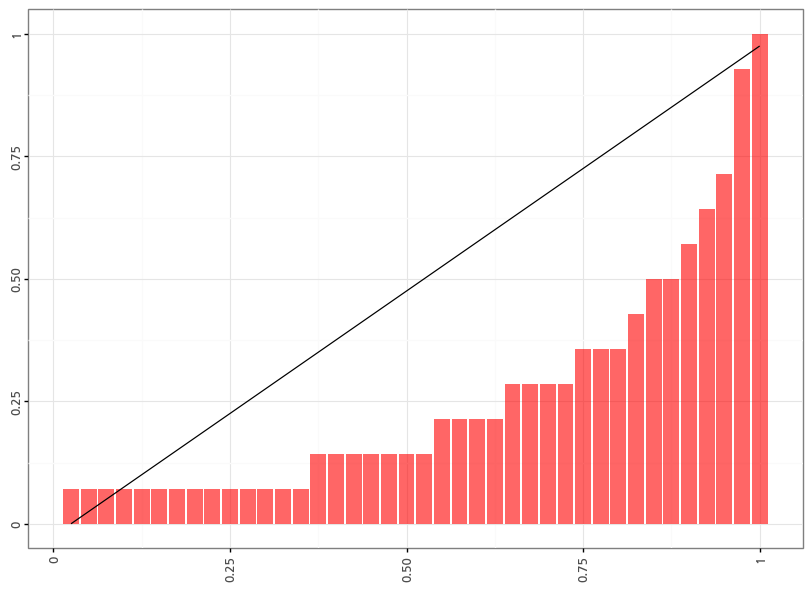


폭행/협박/상해 일반


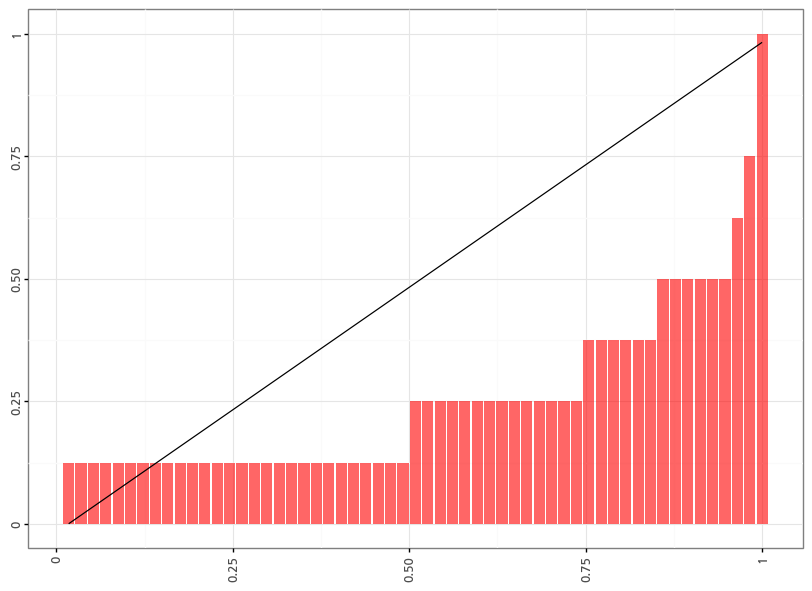


디지털 성범죄


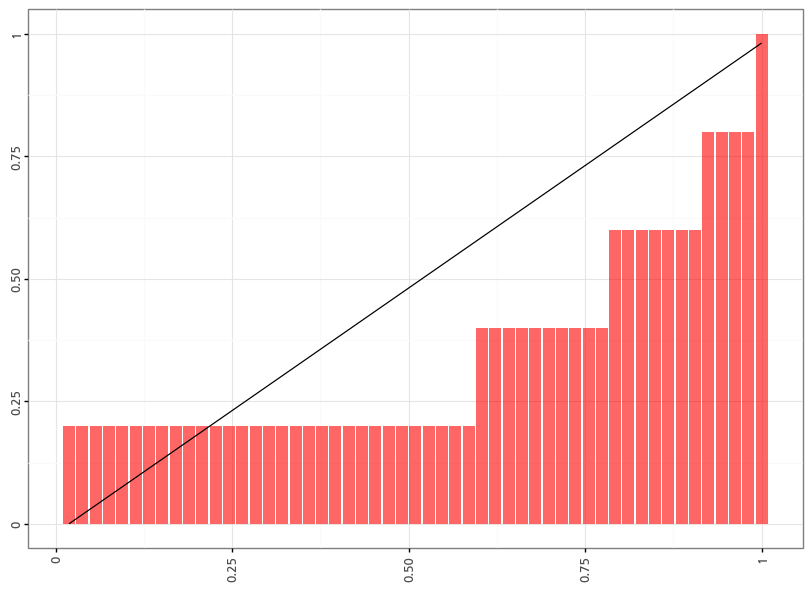


이혼


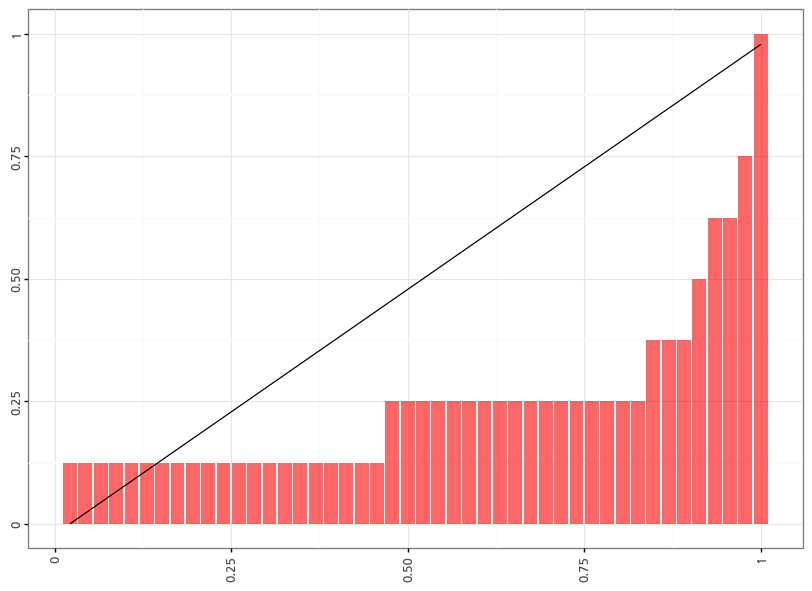


노동/인사


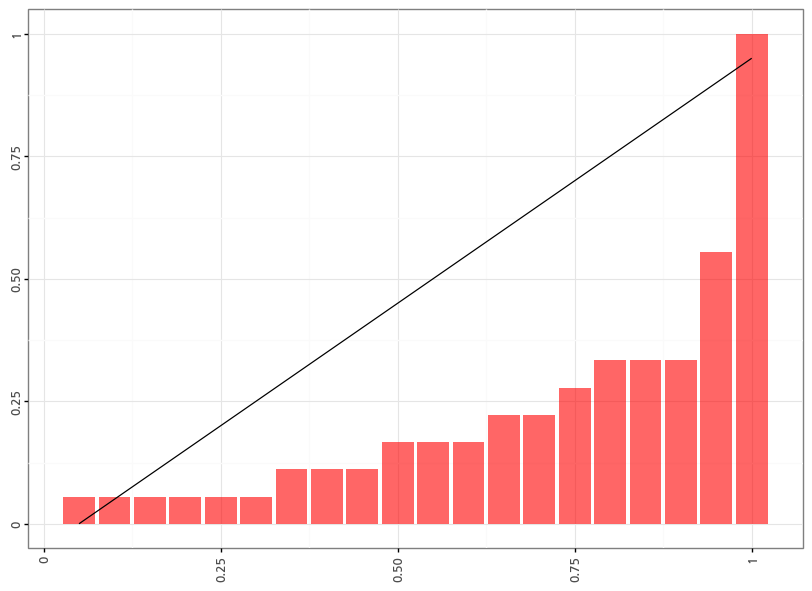


명예훼손/모욕 일반


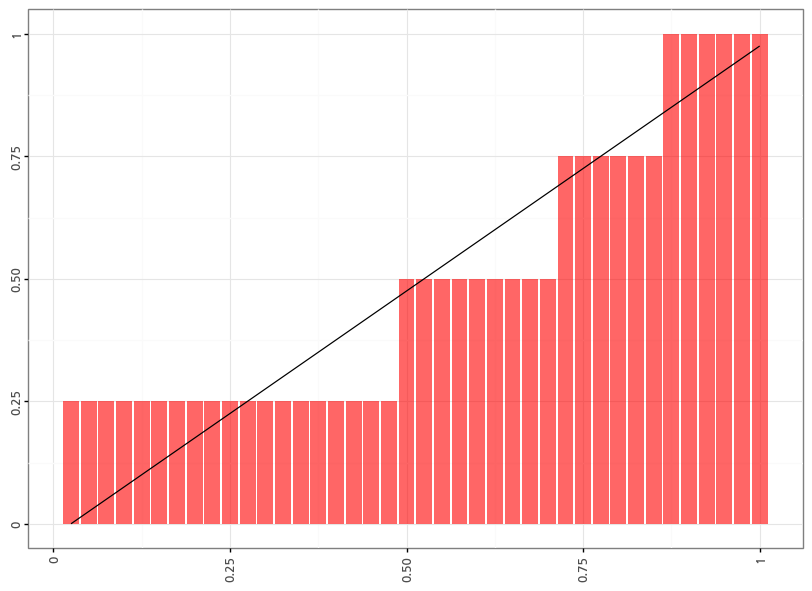


성폭력/강제추행 등


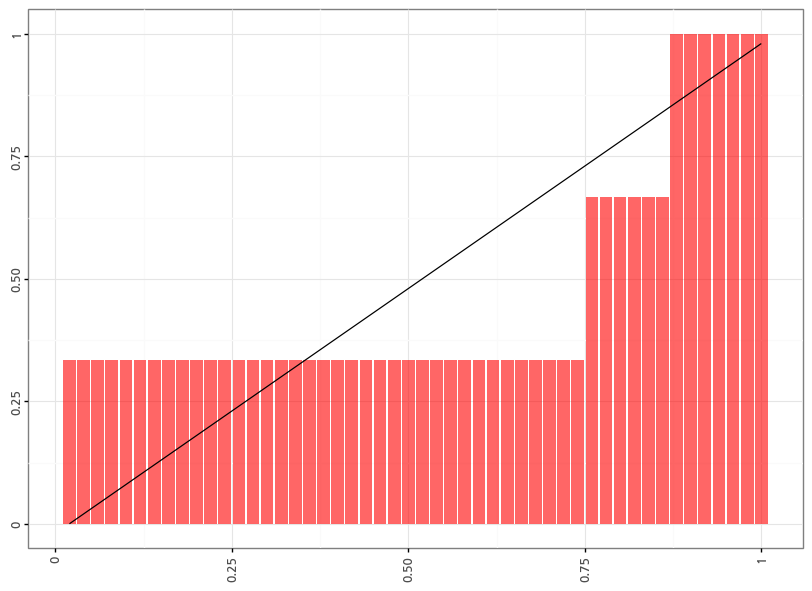


손해배상


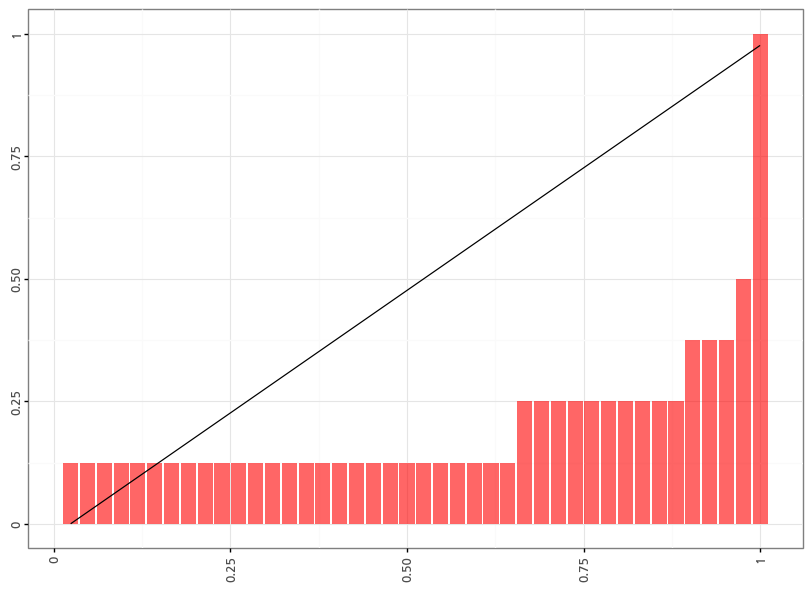


상속


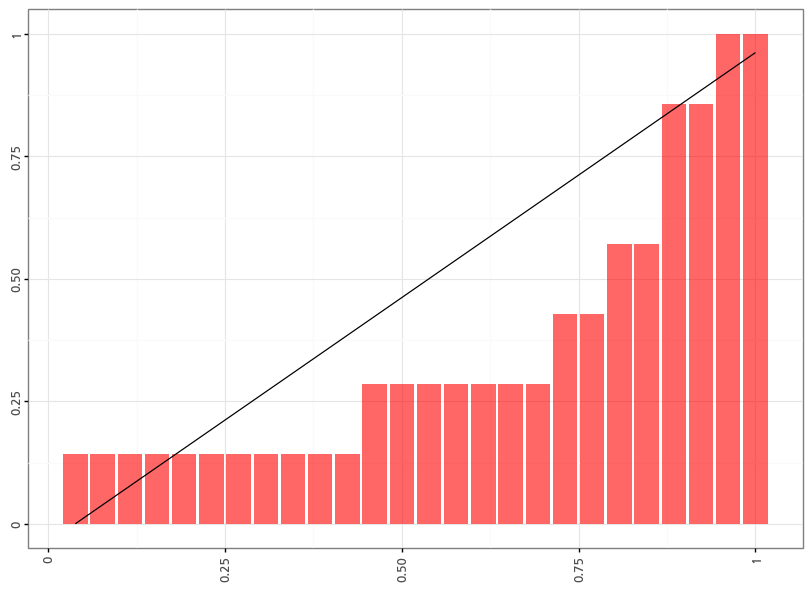

In [37]:
for i in list(advicet.metadata_extraInfo.value_counts()[:10].index) :
    print(i)
    get_gini(advicet[advicet.metadata_extraInfo == i].groupby("slug")._id.count().reset_index(), "_id")

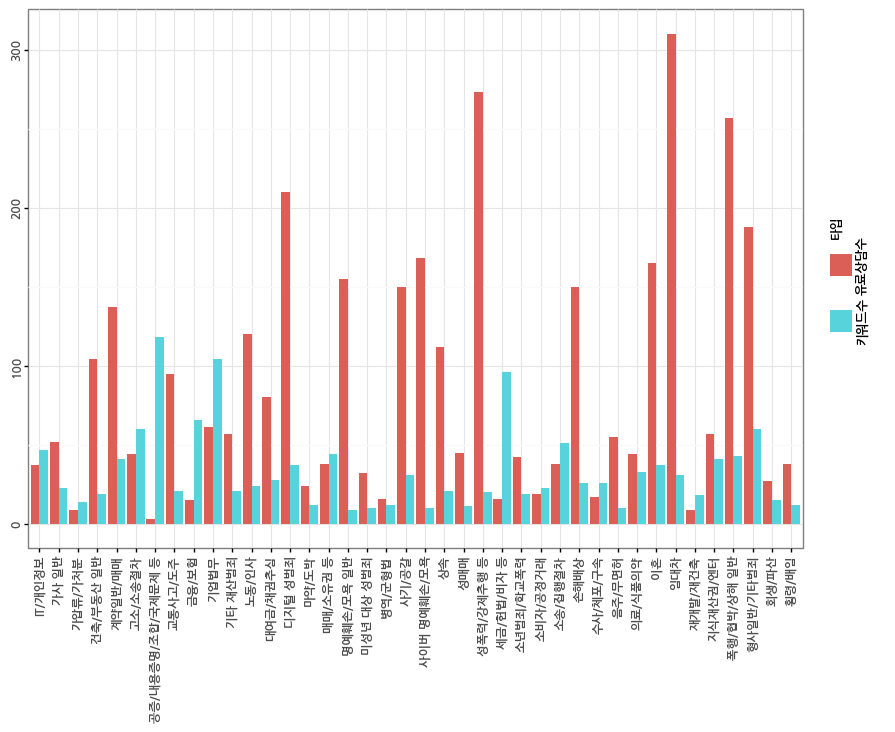

<ggplot: (8775446859234)>

In [45]:

tmp1 = advice.adCategory_name.value_counts().reset_index().assign(tp = "유료상담수")
tmp2 = keyword.groupby("type2").search_keyword.count().reset_index().assign(tp = "키워드수")

tmp1.columns = ["분야", "카운트", "타입"]
tmp2.columns = ["분야", "카운트", "타입"]

(
    ggplot(data = pd.concat([tmp1[tmp1.분야 != '기타'], tmp2], axis = 0)) +
    geom_col(mapping = aes(x = "분야", y = "카운트", fill = "타입"), position = "dodge") +
    theme_bw() +
    theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)
